In [8]:
from dptb.nn.dftb.sk_param import SKParam
from dptb.nn.dftb.hopping_dptb import HoppingIntp
import torch
from dptb.nn.sktb.hopping import HoppingFormula
from dptb.nn.sktb import OnsiteFormula, bond_length_list
from functorch import vmap
import matplotlib.pyplot as plt
from torch.optim import Adam, LBFGS, RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR
from dptb.nn.nnsk import NNSK
from dptb.nn.sktb.onsite import onsite_energy_database
import numpy as np

class dftb:
    def __init__(self, basis, skdata):
        self.param = SKParam(basis=basis, skdata=skdata)
        self.idp_sk = self.param.idp_sk
        self.param = self.param.format_skparams(self.param.skdict)
        self.hopping = HoppingIntp(num_ingrls=self.param["Hopping"].shape[1])
        self.overlap = HoppingIntp(num_ingrls=self.param["Overlap"].shape[1])
        
    def __call__(self, r, mode="hopping"):
        out = []
        for i in range(len(self.idp_sk.bond_types)):
            out.append(self.hopping.get_skhij(rij=r, xx=self.param["Distance"], yy=self.param[mode[0].upper()+mode[1:]][i]))
        return torch.stack(out)
    
class dftb2nnsk:
    def __init__(self, dftb, functype, rs, rc, w):
        self.dftb = dftb
        self.functype = functype
        self.idp_sk = self.dftb.idp_sk
        self.rs = rs
        self.rc = rc
        self.w = w

        self.nnsk_hopping = HoppingFormula(functype=self.functype)
        self.nnsk_overlap = HoppingFormula(functype=self.functype, overlap=True)
        self.hopping_params = torch.nn.Parameter(torch.randn(len(self.idp_sk.bond_types), self.dftb.hopping.num_ingrls, self.nnsk_hopping.num_paras))
        self.overlap_params = torch.nn.Parameter(torch.randn(len(self.idp_sk.bond_types), self.dftb.hopping.num_ingrls, self.nnsk_hopping.num_paras))
        self.E_base = torch.zeros(self.idp_sk.num_types, self.idp_sk.n_onsite_Es)
        for asym, idx in self.idp_sk.chemical_symbol_to_type.items():
            self.E_base[idx] = torch.zeros(self.idp_sk.n_onsite_Es)
            for ot in self.idp_sk.basis[asym]:
                fot = self.idp_sk.basis_to_full_basis[asym][ot]
                self.E_base[idx][self.idp_sk.skonsite_maps[fot]] = onsite_energy_database[asym][ot]

    def symmetrize(self):
        reflective_bonds = np.array([self.idp_sk.bond_to_type["-".join(self.idp_sk.type_to_bond[i].split("-")[::-1])] for i  in range(len(self.idp_sk.bond_types))])
        params = self.hopping_params.data
        reflect_params = params[reflective_bonds]
        for k in self.idp_sk.orbpair_maps.keys():
            iorb, jorb = k.split("-")
            if iorb == jorb:
                # This is to keep the symmetry of the hopping parameters for the same orbital pairs
                # As-Bs = Bs-As; we need to do this because for different orbital pairs, we only have one set of parameters, 
                # eg. we only have As-Bp and Bs-Ap, but not Ap-Bs and Bp-As; and we will use Ap-Bs = Bs-Ap and Bp-As = As-Bp to calculate the hopping integral
                self.hopping_params.data[:,self.idp_sk.orbpair_maps[k],:] = 0.5 * (params[:,self.idp_sk.orbpair_maps[k],:] + reflect_params[:,self.idp_sk.orbpair_maps[k],:])

        params = self.overlap_params.data
        reflect_params = params[reflective_bonds]
        for k in self.idp_sk.orbpair_maps.keys():
            iorb, jorb = k.split("-")
            if iorb == jorb:
                self.overlap_params.data[:,self.idp_sk.orbpair_maps[k],:] = 0.5 * (params[:,self.idp_sk.orbpair_maps[k],:] + reflect_params[:,self.idp_sk.orbpair_maps[k],:])
        
        return True

    def step(self, r):
        
        if r.reshape(-1).shape[0] == 1:
            r = r.reshape(-1)
            r = r.repeat(len(self.idp_sk.bond_types))
        edge_number = self.idp_sk.untransform_bond(torch.arange(len(self.idp_sk.bond_types))).T
        r0 = 0.5*bond_length_list[edge_number-1].sum(0)

        hopping = self.nnsk_hopping.get_skhij(
            rij=r,
            paraArray=self.hopping_params, # [N_edge, n_pairs, n_paras],
            rs=self.rs,
            rc=self.rc,
            w=self.w,
            r0=r0
            ) # [N_edge, n_pairs]
        
        overlap = self.nnsk_overlap.get_skhij(
            rij=r,
            paraArray=self.overlap_params, # [N_edge, n_pairs, n_paras],
            rs=self.rs,
            rc=self.rc,
            w=self.w,
            r0=r0
            )
        
        return hopping, overlap

    def viz(self, r_min=1.5, r_max=5.0):
        with torch.no_grad():
            r = torch.linspace(r_min,r_max, steps=100)
            hops = vmap(self.step)(r.reshape(-1,1))

            dftb_hopping = self.dftb(r, mode="hopping").permute(1,0,2)
            dftb_overlap = self.dftb(r, mode="overlap").permute(1,0,2)

            fig = plt.figure(figsize=(6,4))
            # hops[0] shape - [n_r, n_edge, n_skintegrals]

            for i in range(hops[0].shape[1]):
                plt.plot(r, hops[0][:,i, :-1], c="C"+str(i))
                plt.plot(r, hops[0][:,i, -1], c="C"+str(i))
                plt.plot(r, dftb_hopping[:,i, :-1], c="C"+str(i), linestyle="--")
                plt.plot(r, dftb_hopping[:,i, -1], c="C"+str(i), linestyle="--")
            plt.title("hoppings")
            plt.xlabel("r(A.U.)")
            plt.tight_layout()
            # plt.legend()
            plt.show()

            fig = plt.figure(figsize=(6,4))
            for i in range(hops[1].shape[1]):
                plt.plot(r, hops[1][:,i, :-1], c="C"+str(i))
                plt.plot(r, hops[1][:,i, -1], c="C"+str(i))
                plt.plot(r, dftb_overlap[:,i, :-1], c="C"+str(i), linestyle="--")
                plt.plot(r, dftb_overlap[:,i, -1], c="C"+str(i), linestyle="--")
            plt.title("overlaps")
            plt.xlabel("r(A.U.)")
            plt.tight_layout()
            # plt.legend()
            plt.show()
    
    def optimize(self, r_min=1.5, r_max=5.0, nsample=256, nstep=10000, lr=1., dis_freq=500, method="RMSprop"):
        if method=="RMSprop":
            optimizer = RMSprop([self.hopping_params, self.overlap_params], lr=lr, momentum=0.2)
        elif method=="LBFGS":
            optimizer = LBFGS([self.hopping_params, self.overlap_params], lr=lr)
        else:
            raise NotImplementedError
        
        lrscheduler = ExponentialLR(optimizer, gamma=0.9989)
        self.loss = torch.tensor(0.)

        def closure():
            optimizer.zero_grad()
            r = torch.rand(nsample) * (r_max - r_min) + r_min
            hopping, overlap = vmap(self.step)(r.reshape(-1,1))

            dftb_hopping = self.dftb(r, mode="hopping").permute(1,0,2)
            dftb_overlap = self.dftb(r, mode="overlap").permute(1,0,2)


            self.loss = (hopping - dftb_hopping).abs().mean() + \
                torch.nn.functional.mse_loss(hopping, dftb_hopping).sqrt() + \
                    15*torch.nn.functional.mse_loss(overlap, dftb_overlap).sqrt() + \
                        15*(overlap - dftb_overlap).abs().mean()
            self.loss.backward()
            return self.loss

        for istep in range(nstep):
            if istep % dis_freq == 0:
                print(f"step {istep}, loss {self.loss.item()}, lr {lrscheduler.get_last_lr()[0]}")
            
            optimizer.step(closure)
            lrscheduler.step()
            self.symmetrize()

        self.viz(r_min=r_min, r_max=r_max)
        return True
    
    def to_nnsk(self):
        nnsk = NNSK(
            idp_sk=self.dftb.idp_sk, 
            onsite={"method": "uniform"},
            hopping={"method": self.functype, "rs":self.rs, "w": self.w, "rc": self.rc},
            overlap=True,
            )
    
        
        nnsk.hopping_param.data = self.hopping_params.data
        nnsk.overlap_param.data = self.overlap_params.data
        nnsk.onsite_param.data = self.dftb.param["OnsiteE"] - self.E_base[torch.arange(len(self.idp_sk.type_names))].unsqueeze(-1)

        return nnsk

In [15]:
fun = dftb(basis={"Mo":["5s","5p"], "S": ["3s","3p"]}, skdata='/personal/tool/prior.pth')
tonnsk = dftb2nnsk(dftb=fun, functype="poly3pow", rs=5.0, rc=6.0, w=0.3)

step 0, loss 0.0, lr 0.1
step 1000, loss 0.1752234250307083, lr 0.03326696098834091
step 2000, loss 0.09298449009656906, lr 0.011066906933997932
step 3000, loss 0.08846408873796463, lr 0.0036816236123490796
step 4000, loss 0.0873192846775055, lr 0.0012247642908577111
step 5000, loss 0.08391556888818741, lr 0.0004074418588387648
step 6000, loss 0.08488677442073822, lr 0.00013554352423006256
step 7000, loss 0.086375892162323, lr 4.5091211327837214e-05
step 8000, loss 0.08518209308385849, lr 1.5000475681601963e-05
step 9000, loss 0.0904228538274765, lr 4.990202393064074e-06


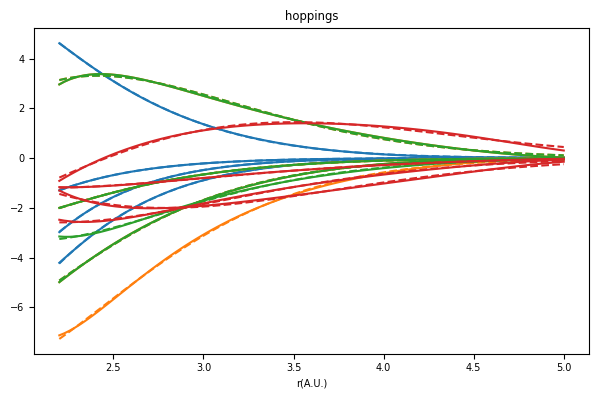

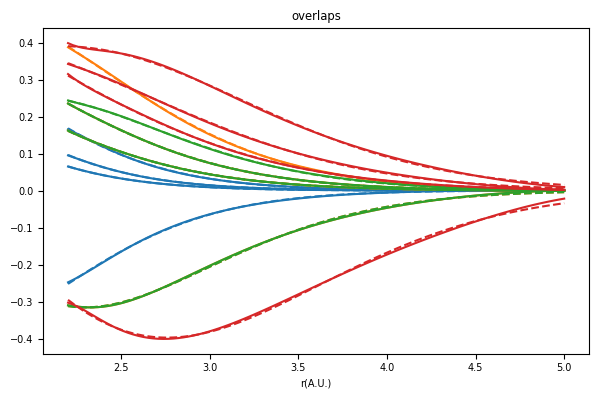

True

In [16]:
tonnsk.optimize(lr=1e-1, r_min=2.2, r_max=5.0, nstep=10000, dis_freq=1000, nsample=64, method="RMSprop")

In [17]:
nnsk = tonnsk.to_nnsk()

In [18]:
from dptb.postprocess.bandstructure.band import Band

band = Band(model=nnsk)

In [19]:
band.get_bands(
    data="/root/deeptb/examples/mos2/data/struct.vasp",
    kpath_kwargs={
        "kline_type":"abacus",
        "kpath":[
            [0, 0, 0, 30],
            [0.5, 0, 0, 30],
            [0.3333333, 0.3333333, 0, 30],
            [0, 0, 0, 1]
        ],
        "nel_atom":{"Mo":6,"S":6},
        "klabels":["G", "M", "K", "G"],
        "E_fermi":-12.798759460449219,
        "emin":-25,
        "emax":15,
        "ref_band": "./data/kpath.0/eigenvalues.npy"
    },
    AtomicData_options={
        "r_max": 5.0,
        "pbc": True,
    }
    )

{'klist': array([[0.        , 0.        , 0.        ],
        [0.01666667, 0.        , 0.        ],
        [0.03333333, 0.        , 0.        ],
        [0.05      , 0.        , 0.        ],
        [0.06666667, 0.        , 0.        ],
        [0.08333333, 0.        , 0.        ],
        [0.1       , 0.        , 0.        ],
        [0.11666667, 0.        , 0.        ],
        [0.13333333, 0.        , 0.        ],
        [0.15      , 0.        , 0.        ],
        [0.16666667, 0.        , 0.        ],
        [0.18333333, 0.        , 0.        ],
        [0.2       , 0.        , 0.        ],
        [0.21666667, 0.        , 0.        ],
        [0.23333333, 0.        , 0.        ],
        [0.25      , 0.        , 0.        ],
        [0.26666667, 0.        , 0.        ],
        [0.28333333, 0.        , 0.        ],
        [0.3       , 0.        , 0.        ],
        [0.31666667, 0.        , 0.        ],
        [0.33333333, 0.        , 0.        ],
        [0.35      , 0.  

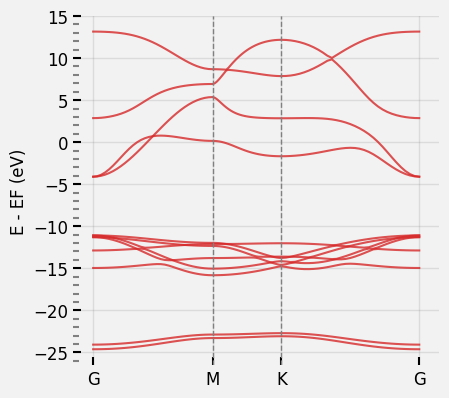

In [20]:
band.band_plot()